# AB Testing

## Import Library

In [434]:
import pandas as pd
import numpy as np
from scipy.stats import norm, beta
from statsmodels.stats.proportion import proportions_ztest
import datetime
import seaborn as sns
import matplotlib.pyplot as plt


## Import Data

In [421]:
ab_df = pd.read_csv('https://raw.githubusercontent.com/AnshulSGarg/AB-Testing/main/ab_data.csv')
ab_df

,user_id,timestamp,group,landing_page,converted
0,851104,1/21/2017 22:11,control,old_page,0
1,804228,1/12/2017 8:01,control,old_page,0
2,661590,1/11/2017 16:55,treatment,new_page,0
3,853541,1/8/2017 18:28,treatment,new_page,0
4,864975,1/21/2017 1:52,control,old_page,1
...,...,...,...,...,...
294473,751197,1/3/2017 22:28,control,old_page,0
294474,945152,1/12/2017 0:51,control,old_page,0
294475,734608,1/22/2017 11:45,control,old_page,0
294476,697314,1/15/2017 1:20,control,old_page,0


In [422]:
ab_df.loc[:,'timestamp'] = pd.to_datetime(ab_df['timestamp'])
ab_df

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:00,control,old_page,0
1,804228,2017-01-12 08:01:00,control,old_page,0
2,661590,2017-01-11 16:55:00,treatment,new_page,0
3,853541,2017-01-08 18:28:00,treatment,new_page,0
4,864975,2017-01-21 01:52:00,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:00,control,old_page,0
294474,945152,2017-01-12 00:51:00,control,old_page,0
294475,734608,2017-01-22 11:45:00,control,old_page,0
294476,697314,2017-01-15 01:20:00,control,old_page,0


## Data Validation

In [423]:
ab_df.isna().values.any()

False

There are no missing values in dataset

In [424]:
print('Check if there are duplicates')
count_df = ab_df.groupby('user_id').count().reset_index()
duplicate_df = count_df[count_df['group']>1][['user_id','group']]
duplicate_df

Check if there are duplicates


,user_id,group
43,630052,2
111,630126,2
122,630137,2
281,630320,2
420,630471,2
...,...,...
290244,945627,2
290259,945645,2
290315,945703,2
290399,945797,2


In [425]:
duplicate_df = ab_df[ab_df['user_id'].isin(duplicate_df['user_id'])].sort_values(by='user_id')

In [426]:
print(len(duplicate_df)/len(ab_df))

0.026446797383845314


Seems like 3894 users have multiple records and they are exposed to both new and old landing page.
if we exclude these users from the dataset we will loose only 2.6% of total records. 
Loosing 2.6% of data records should be okay in this case. 



In [427]:
ab_df = ab_df[~ab_df['user_id'].isin(duplicate_df['user_id'])]
ab_df

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:00,control,old_page,0
1,804228,2017-01-12 08:01:00,control,old_page,0
2,661590,2017-01-11 16:55:00,treatment,new_page,0
3,853541,2017-01-08 18:28:00,treatment,new_page,0
4,864975,2017-01-21 01:52:00,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:00,control,old_page,0
294474,945152,2017-01-12 00:51:00,control,old_page,0
294475,734608,2017-01-22 11:45:00,control,old_page,0
294476,697314,2017-01-15 01:20:00,control,old_page,0


In [428]:
ab_df.groupby('user_id').count().reset_index().sort_values(by='group', ascending=False)

,user_id,timestamp,group,landing_page,converted
0,630000,1,1,1,1
191124,840746,1,1,1,1
191130,840752,1,1,1,1
191129,840751,1,1,1,1
191128,840750,1,1,1,1
...,...,...,...,...,...
95569,735348,1,1,1,1
95570,735349,1,1,1,1
95571,735350,1,1,1,1
95572,735351,1,1,1,1


In [429]:
ab_df.groupby(['group','landing_page']).count()

,,user_id,timestamp,converted
group,landing_page,,,
control,old_page,143293,143293,143293
treatment,new_page,143397,143397,143397


After removing duplicates, updated dataset has control group that is exposed to only old_page and treatment group is only exposed to new_page.

In [430]:
ab_df.groupby(['group','converted']).count()

user_id  timestamp  landing_page
group     converted                                  
control   0           126073     126073        126073
          1            17220      17220         17220
treatment 0           126372     126372        126372
          1            17025      17025         17025

# Frequentist Test

In [393]:
control_df = ab_df[ab_df['group']=='control']
treatment_df = ab_df[ab_df['group']=='treatment']



In [394]:
control_group_count = len(control_df)
treatment_group_count = len(treatment_df)

print(f'control group count is {control_group_count}')
print(f'treatment group count is {treatment_group_count}')

control group count is 143293
treatment group count is 143397


In [395]:
control_group_conversion_count = len(control_df[control_df['converted'] == 1])
treatment_group_conversion_count = len(treatment_df[treatment_df['converted'] == 1])

print(f'count of control group conversion is {control_group_conversion_count}')
print(f'count of treatment group conversion is {treatment_group_conversion_count}')

count of control group conversion is 17220
count of treatment group conversion is 17025


In [396]:
control_group_conversion_rate = len(control_df[control_df['converted'] == 1])/len(control_df)
treatment_group_conversion_rate = len(treatment_df[treatment_df['converted'] == 1])/len(treatment_df)

print(f'mean of control group conversion is {control_group_conversion_rate}')
print(f'mean of treatment group conversion is {treatment_group_conversion_rate}')

mean of control group conversion is 0.12017335110577627
mean of treatment group conversion is 0.11872633318688676


## Hypothesis Test

H0 = There is no signaficant difference b/w mean of control group and treatement group conversion  
H1 = mean of treatement group conversion > mean of control group conversion

In [450]:
def two_sample_test_for_proportions(c, t, nc, nt):
    combined_p = (c+t)/(nc+nt)
    # print(f'combined_p is {combined_p}')
    Z = (((t/nt)-(c/nc)) - 0) / (combined_p * (1-combined_p) * ((1/nt)+(1/nc)))**.5

    mu = (((t/nt)-(c/nc)) - 0)
    sd = (combined_p * (1-combined_p) * ((1/nt)+(1/nc)))**.5
    
    
    print(f'mean is {(((t/nt)-(c/nc)) - 0)}')
    print(f'standard deviation is {(combined_p * (1-combined_p) * ((1/nt)+(1/nc)))**.5}')
    print(f'Z statistics is {Z}')
    return [Z, mu, sd]

In [451]:
z_statistic = two_sample_test_for_proportions(control_group_conversion_count,treatment_group_conversion_rate,control_group_count,treatment_group_count)

mean is -0.12017252699610162
standard deviation is 0.000887532748952894
Z statistics is -135.4006679053595


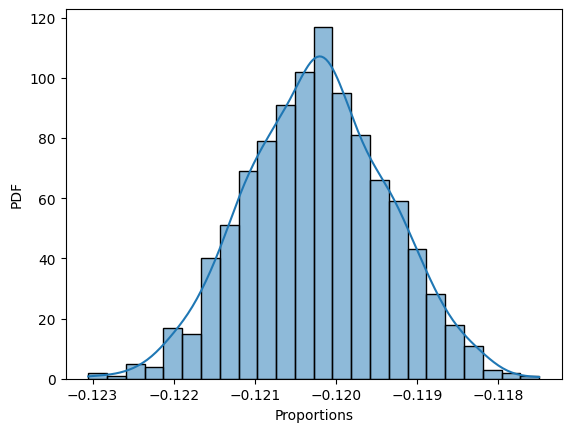

In [472]:
data = np.random.normal(z_statistic[1], z_statistic[2], 1000)
sns.histplot(data, kde=True)
plt.xlabel('Proportions')
plt.ylabel('PDF')
plt.show()  

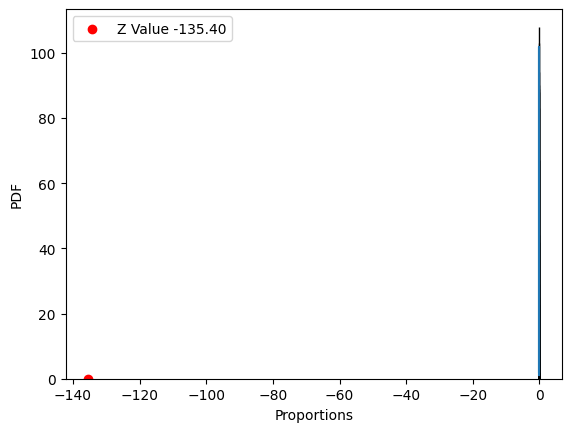

In [481]:
data = np.random.normal(z_statistic[1], z_statistic[2], 1000)
sns.histplot(data, kde=True)
plt.xlabel('Proportions')
plt.ylabel('PDF')
plt.scatter(z_statistic[0], [0], color='red', label=f'Z Value {z_statistic[0]:.2f}')
plt.legend()
plt.show()   

In [399]:
# Calculate the two-tailed p-value
p_value = 2 * (1 - norm.cdf(abs(z_statistic)))

# Print the result
print(f"P-value is {p_value}")

# Check the significance level (commonly 0.05)
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null hypothesis")

P-value is 0.0
Reject the null hypothesis


In [400]:
# p value using statsmodels.stats.proportion library

stat, p_value = proportions_ztest([control_group_conversion_count, treatment_group_conversion_rate], [control_group_count, treatment_group_count])

# Output the results
print(f"Z-statistic: {stat}")
print(f"P-value: {p_value}")

# Check the significance level (commonly 0.05)
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null hypothesis")


Z-statistic: 135.40066154264042
P-value: 0.0
Reject the null hypothesis


# Bayesian Test

In [401]:
min_date = ab_df['timestamp'].min()
max_date = ab_df['timestamp'].max()

print(max_date)
print(min_date)

print(f'Data collection done for {max_date - min_date}')

2017-01-24 13:41:00
2017-01-02 13:42:00
Data collection done for 21 days 23:59:00


In [418]:
ab_df.loc[:,'Week'] = ab_df['timestamp'].apply(lambda x: x.isocalendar()[1])
ab_df

,user_id,timestamp,group,landing_page,converted,Week
0,851104,2017-01-21 22:11:00,control,old_page,0,3
1,804228,2017-01-12 08:01:00,control,old_page,0,2
2,661590,2017-01-11 16:55:00,treatment,new_page,0,2
3,853541,2017-01-08 18:28:00,treatment,new_page,0,1
4,864975,2017-01-21 01:52:00,control,old_page,1,3
...,...,...,...,...,...,...
294473,751197,2017-01-03 22:28:00,control,old_page,0,1
294474,945152,2017-01-12 00:51:00,control,old_page,0,2
294475,734608,2017-01-22 11:45:00,control,old_page,0,3
294476,697314,2017-01-15 01:20:00,control,old_page,0,2


In [404]:
ab_df.groupby(['group','Week']).count()

user_id  timestamp  landing_page  converted
group     Week                                             
control   1       41731      41731         41731      41731
          2       45685      45685         45685      45685
          3       45538      45538         45538      45538
          4       10339      10339         10339      10339
treatment 1       42014      42014         42014      42014
          2       45695      45695         45695      45695
          3       45518      45518         45518      45518
          4       10170      10170         10170      10170

In [405]:
wk = 1
Prior_Dataset = ab_df[ab_df['Week']==wk]
Prior_Dataset

,user_id,timestamp,group,landing_page,converted,Week
3,853541,2017-01-08 18:28:00,treatment,new_page,0,1
8,817355,2017-01-04 17:58:00,treatment,new_page,1,1
17,888545,2017-01-08 06:37:00,treatment,new_page,1,1
26,892356,2017-01-05 09:35:00,treatment,new_page,1,1
29,736159,2017-01-06 01:50:00,treatment,new_page,0,1
...,...,...,...,...,...,...
294465,925675,2017-01-07 20:38:00,treatment,new_page,0,1
294467,857744,2017-01-05 08:00:00,control,old_page,0,1
294468,643562,2017-01-02 19:20:00,treatment,new_page,0,1
294472,822004,2017-01-04 03:36:00,treatment,new_page,0,1


In [406]:
control_prior_df = Prior_Dataset[Prior_Dataset['group']=='control']
treatment_prior_df = Prior_Dataset[Prior_Dataset['group']=='treatment']

In [407]:
control_group_conversion_rate = len(control_prior_df[control_prior_df['converted'] == 1])/len(control_prior_df)
treatment_group_conversion_rate = len(treatment_prior_df[treatment_prior_df['converted'] == 1])/len(treatment_prior_df)

print(f'Week : {wk}')
print(f'mean of control group conversion is {round(control_group_conversion_rate*100,2)}%')
print(f'mean of treatment group conversion is {round(treatment_group_conversion_rate*100,2)}%')
prior_lift = round((treatment_group_conversion_rate - control_group_conversion_rate) / control_group_conversion_rate , 3)
print(f"Prior Lift = {prior_lift}%")

Week : 1
mean of control group conversion is 11.92%
mean of treatment group conversion is 11.78%
Prior Lift = -0.011%


In [408]:
prior_means = []
for i in range(10000):
    prior_means.append(control_prior_df.sample(1000)['converted'].mean())

In [409]:
mean_value = sum(prior_means) / len(prior_means)
print(mean_value)

0.11908710000000074


In [410]:
posterier_wk = 2
Posterier_Dataset = ab_df[(ab_df['Week'] > 1) & (ab_df['Week']<=posterier_wk)]
Posterier_Dataset

,user_id,timestamp,group,landing_page,converted,Week
1,804228,2017-01-12 08:01:00,control,old_page,0,2
2,661590,2017-01-11 16:55:00,treatment,new_page,0,2
5,936923,2017-01-10 15:20:00,control,old_page,0,2
9,839785,2017-01-15 18:11:00,treatment,new_page,1,2
12,803683,2017-01-09 06:05:00,treatment,new_page,0,2
...,...,...,...,...,...,...
294461,740310,2017-01-10 17:22:00,control,old_page,0,2
294466,923948,2017-01-09 16:33:00,control,old_page,0,2
294470,908354,2017-01-11 02:42:00,control,old_page,0,2
294474,945152,2017-01-12 00:51:00,control,old_page,0,2


In [411]:
control_posterier_df = Posterier_Dataset[Posterier_Dataset['group']=='control']
treatment_posterier_df = Posterier_Dataset[Posterier_Dataset['group']=='treatment']

In [412]:
control_group_conversion_rate = len(control_posterier_df[control_posterier_df['converted'] == 1])/len(control_posterier_df)
treatment_group_conversion_rate = len(treatment_posterier_df[treatment_posterier_df['converted'] == 1])/len(treatment_posterier_df)

print(f'Dataset for week 1 to {posterier_wk}')
print(f'mean of control group conversion is {round(control_group_conversion_rate*100,2)}%')
print(f'mean of treatment group conversion is {round(treatment_group_conversion_rate*100,2)}%')
posterier_lift = round((treatment_group_conversion_rate - control_group_conversion_rate) / control_group_conversion_rate , 3)
print(f"Posterier Lift = {posterier_lift}%")

Dataset for week 1 to 2
mean of control group conversion is 11.93%
mean of treatment group conversion is 11.82%
Posterier Lift = -0.009%


In [413]:
prior_alpha, prior_beta, _, _ = beta.fit(prior_means, floc=0, fscale=1)

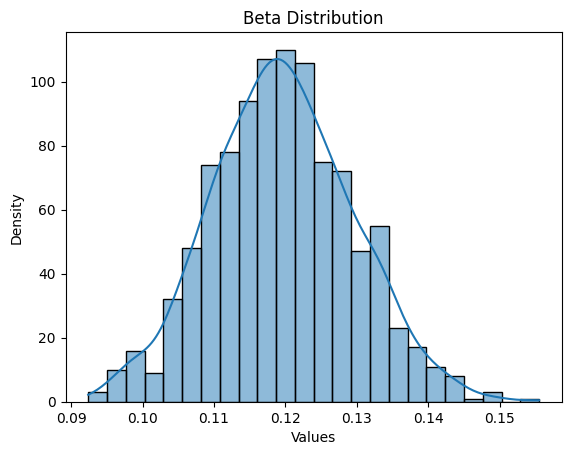

In [482]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import beta

# Parameters for the Beta distribution (alpha and beta)
alpha_param = prior_alpha
beta_param = prior_beta

# Generate random data following a Beta distribution
data_beta = beta.rvs(alpha_param, beta_param, size=1000)

# Plot the Beta distribution using seaborn
sns.histplot(data_beta, kde=True)
plt.xlabel('Values')
plt.ylabel('Density')
plt.title('Beta Distribution')

plt.show()


## Update Prior information

In [414]:
posterior_control = beta(prior_alpha + len(control_posterier_df[control_posterier_df['converted'] == 1]), prior_beta + (len(control_posterier_df) - len(control_posterier_df[control_posterier_df['converted'] == 1])))
posterior_treatment = beta(prior_alpha + len(treatment_posterier_df[treatment_posterier_df['converted'] == 1]), prior_beta + (len(treatment_posterier_df) - len(treatment_posterier_df[treatment_posterier_df['converted'] == 1])))

## Random sampling from posterior parameters

In [415]:
control_samples = posterior_control.rvs(1000)
treatment_samples = posterior_treatment.rvs(1000)
probability = np.mean(treatment_samples > control_samples)
print(f"Probability that treatment > control: {probability * 100}%")

Probability that treatment > control: 31.3%


In [416]:
(control_mu), (control_var) = posterior_control.stats()
(treatment_mu), (treatment_var) = posterior_treatment.stats()
print(f"Control Posterior: Mean: {control_mu}, Variance: {control_var}") 
print(f"Treatment Posterior: Mean: {treatment_mu}, Variance: {treatment_var}") 

Control Posterior: Mean: 0.11924780218951651, Variance: 2.2487396473519885e-06
Treatment Posterior: Mean: 0.11819474955618357, Variance: 2.2310687161720355e-06


In [417]:
lift_percentage = (treatment_samples - control_samples) / control_samples
print(f"Probability that we are seeing a 2% lift: {np.mean((100 * lift_percentage) > 2) * 100}%")

Probability that we are seeing a 2% lift: 4.9%
